<a href="https://colab.research.google.com/github/om-umrania/KGAT-Knowledge-Graph-Attention-Network-for-Recommendation/blob/main/KGAT_Implemented_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load and Prepare Data

In [50]:
import pandas as pd

# Load synthetic data
interactions_df = pd.read_csv('synthetic_user_item_interactions_multimedia.csv')
item_attributes_df = pd.read_csv('synthetic_item_attributes_multimedia.csv')
kg_relations_df = pd.read_csv('synthetic_knowledge_graph_relations_multimedia.csv')

# Display the first few rows of each DataFrame to ensure data is loaded correctly
print("User-Item Interactions:")
print(interactions_df.head())

print("\nItem-Attribute Relationships:")
print(item_attributes_df.head())

print("\nKnowledge Graph Relations:")
print(kg_relations_df.head())


User-Item Interactions:
   user_id  item_id
0        1        1
1        1        8
2        1       20
3        1       22
4        1       26

Item-Attribute Relationships:
   item_id category  attribute_id
0        1     code             2
1        1     code             5
2        1     code            34
3        2     code            34
4        3     code            12

Knowledge Graph Relations:
   item_id category  attribute_id  related_item_id
0        1     code             2              537
1        1     code             2              591
2        1     code             5              713
3        1     code             5               10
4        1     code            34               90


# Preprocess Data for GNN/GAT

In [51]:
import torch

# Assume you have 'num_classes' as the number of classes for your classification task
num_classes = 2  # Example: binary classification

# Randomly generate labels for each node
data.y = torch.randint(0, num_classes, (data.num_nodes,))

# Verify the labels are set correctly
print(data.y)


tensor([0, 0, 1,  ..., 0, 0, 1])


In [52]:
!pip install torch-geometric

In [53]:
import networkx as nx
import numpy as np
import torch
from torch_geometric.data import Data
from torch_geometric.utils import from_networkx

# Convert user-item interactions to a graph
G = nx.Graph()

# Add edges for user-item interactions
for index, row in interactions_df.iterrows():
    user_id = f"user_{row['user_id']}"
    item_id = f"item_{row['item_id']}"
    G.add_edge(user_id, item_id)

# Add edges for item-attribute relationships
for index, row in item_attributes_df.iterrows():
    item_id = f"item_{row['item_id']}"
    attribute_id = f"attr_{row['attribute_id']}"
    G.add_edge(item_id, attribute_id)

# Add edges for knowledge graph relationships
for index, row in kg_relations_df.iterrows():
    item_id = f"item_{row['item_id']}"
    related_item_id = f"item_{row['related_item_id']}"
    G.add_edge(item_id, related_item_id)

# Convert the NetworkX graph to PyTorch Geometric Data object
data = from_networkx(G)

# Display the PyTorch Geometric Data object
print(data)


Data(edge_index=[2, 168906], num_nodes=1850)


# Build the KGAT Model Using GNN and GAT

In [54]:
import torch.nn.functional as F
from torch_geometric.nn import GATConv, GCNConv

class KGAT(torch.nn.Module):
    def __init__(self, num_node_features, hidden_channels, num_classes):
        super(KGAT, self).__init__()
        self.conv1 = GCNConv(num_node_features, hidden_channels)
        self.conv2 = GATConv(hidden_channels, hidden_channels)
        self.conv3 = GATConv(hidden_channels, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        # First GCN layer
        x = self.conv1(x, edge_index)
        x = F.relu(x)

        # Two GAT layers
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.conv3(x, edge_index)

        return F.log_softmax(x, dim=1)  # Explicitly return the output


# Initialize the model, define the loss and optimizer
model = KGAT(num_node_features=data.num_node_features, hidden_channels=16, num_classes=2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()


# Train the Model

In [55]:
# Convert the NetworkX graph to PyTorch Geometric Data object
data = from_networkx(G)

# If your nodes don't have features, you can initialize them with a constant vector
if data.x is None:
    data.x = torch.ones(data.num_nodes, 1)  # Example: initialize with a vector of ones

import torch_geometric.transforms as T
transform = T.RandomNodeSplit(split='train_rest', num_val=0.2, num_test=0.2)

# Apply the transform to the data object
data = transform(data)

# Display the PyTorch Geometric Data object
print(data)

Data(edge_index=[2, 168906], num_nodes=1850, x=[1850, 1])


In [56]:
# Assume you have 'num_nodes' as the total number of nodes in your graph
num_nodes = data.num_nodes

# Create random train/test splits
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask = torch.zeros(num_nodes, dtype=torch.bool)

# Specify the number of training and testing nodes
num_train = int(num_nodes * 0.8)  # 80% for training
num_test = num_nodes - num_train   # 20% for testing

# Randomly select nodes for training and testing
train_mask[:num_train] = True
test_mask[num_train:] = True

# Shuffle the masks
perm = torch.randperm(num_nodes)
train_mask = train_mask[perm]
test_mask = test_mask[perm]

# Assign masks to the data object
data.train_mask = train_mask
data.test_mask = test_mask

print(data.y)  # This should output a tensor, not None


None


In [59]:
import torch

# Assume you have 'num_classes' as the number of classes for your classification task
num_classes = 2  # Example: binary classification

# Randomly generate labels for each node
data.y = torch.randint(0, num_classes, (data.num_nodes,))

# Verify the labels are set correctly
print(data.y)


tensor([1, 0, 0,  ..., 0, 1, 1])


In [60]:
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data)
    print(out[data.train_mask].shape)  # Check the shape of the model output
    print(data.y[data.train_mask].shape)  # Check the shape of the labels
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

def test():
    model.eval()
    _, pred = model(data).max(dim=1)
    correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
    acc = int(correct) / int(data.test_mask.sum())
    return acc

print(data.train_mask.sum().item())  # This should be greater than 0
print(data.test_mask.sum().item())  # This should be greater than 0


# Training loop
for epoch in range(1, 201):
    loss = train()
    if epoch % 10 == 0:
        train_acc = test()
        print(f'Epoch: {epoch}, Loss: {loss:.4f}, Test Acc: {train_acc:.4f}')


1480
370
torch.Size([1480, 2])
torch.Size([1480])
torch.Size([1480, 2])
torch.Size([1480])
torch.Size([1480, 2])
torch.Size([1480])
torch.Size([1480, 2])
torch.Size([1480])
torch.Size([1480, 2])
torch.Size([1480])
torch.Size([1480, 2])
torch.Size([1480])
torch.Size([1480, 2])
torch.Size([1480])
torch.Size([1480, 2])
torch.Size([1480])
torch.Size([1480, 2])
torch.Size([1480])
torch.Size([1480, 2])
torch.Size([1480])
Epoch: 10, Loss: 0.6936, Test Acc: 0.5459
torch.Size([1480, 2])
torch.Size([1480])
torch.Size([1480, 2])
torch.Size([1480])
torch.Size([1480, 2])
torch.Size([1480])
torch.Size([1480, 2])
torch.Size([1480])
torch.Size([1480, 2])
torch.Size([1480])
torch.Size([1480, 2])
torch.Size([1480])
torch.Size([1480, 2])
torch.Size([1480])
torch.Size([1480, 2])
torch.Size([1480])
torch.Size([1480, 2])
torch.Size([1480])
torch.Size([1480, 2])
torch.Size([1480])
Epoch: 20, Loss: 0.6933, Test Acc: 0.5459
torch.Size([1480, 2])
torch.Size([1480])
torch.Size([1480, 2])
torch.Size([1480])
torch

# Visualization

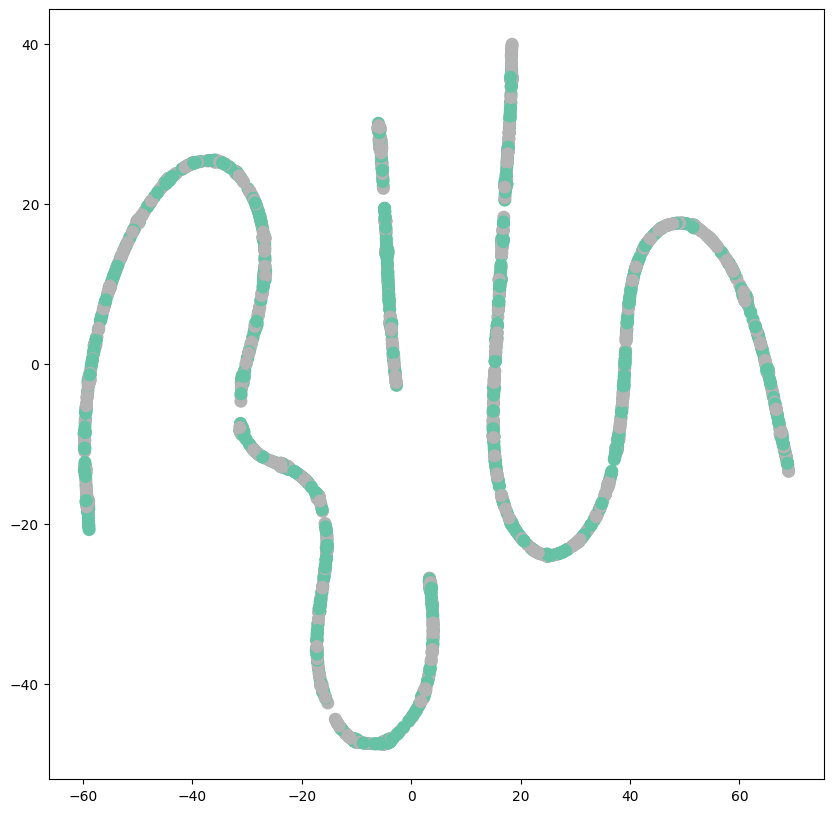

In [61]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Extract embeddings from the last hidden layer
model.eval()
with torch.no_grad():
    out = model(data)

# Apply t-SNE for visualization
z = TSNE(n_components=2).fit_transform(out.cpu().numpy())

plt.figure(figsize=(10, 10))
plt.scatter(z[:, 0], z[:, 1], s=70, c=data.y.cpu(), cmap="Set2")
plt.show()
